# Introduction

This code demonstrates evaluates the effectiveness of an attention component for reducing oversmoothing for graph convolutional networks on the Cora dataset  for question  3 of the Graph Representation Learning Mini-project and is built from code from Practical 4.
MADGap is uses as a measure of oversmoothness to analyse the effectiveness of the attention component to reducing oversmoothing.

# Code Setup

This section installs the necessary packages and loads the Cora dataset. It downgrades the version of pytorch to one supported by torch_geometric.

In [1]:
!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchtext==0.13.0 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |██████████████▌                 | 834.1 MB 1.3 MB/s eta 0:13:05tcmalloc: large alloc 1147494400 bytes == 0x3984c000 @  0x7f44c9f77615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████▍             | 1055.7 MB 1.2 MB/s eta 0:10:51tcmalloc: large alloc 1434370048 bytes == 0x7dea2000 @  0x7f44c9f77615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |█████

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.0+cu113
     |████████████████████████████████| 8.9 MB 24.0 MB/s 
     |████████████████████████████████| 3.5 MB 28.0 MB/s 
     |████████████████████████████████| 2.5 MB 20.0 MB/s 
     |████████████████████████████████| 280 kB 35.7 MB/s 


In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

device = "cuda"

from torch_geometric.nn import GCNConv,GATConv

In [4]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


# Model Definitions

This section contains the model definitions.

In [ ]:
class EndLayer(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(EndLayer,self).__init__()
        self.layer=nn.Linear(input_dim,output_dim)
        self.LL=nn.LogSoftmax(dim=1)
        self.for_embeddings=False
    
    def forward(self,X,edge_index):
        x=self.layer(X)
        return self.LL(x)

    def param_init(self):
        self.layer.reset_parameters()
        nn.init.xavier_uniform_(self.layer.weight)

In [ ]:
class Sequence(nn.Module):

    def __init__(self,modules):
        super(Sequence,self).__init__()
        self.layers=nn.ModuleList(modules)

    def forward(self,X,edge_index):
        x=X
        for module in self.layers:
            x=module(x,edge_index)
        return x

    def generate_node_embeddings(self,X,edge_index):
        x=X
        for module in self.layers:
            if module.for_embeddings:
                x=module(x,edge_index)
        return x

    def param_init(self):
        for module in self.layers:
            module.param_init()

In [ ]:
class GCNLayer(nn.Module):

    def __init__(self,input_dim,output_dim,dropout_ratio=0.3,act_fn=nn.ReLU()):
        super(GCNLayer,self).__init__()
        self.dropout=nn.Dropout(p=dropout_ratio)
        self.layer=GCNConv(input_dim,output_dim)
        self.act_fn=act_fn
        self.for_embeddings=True

    def forward(self,X,edge_index):
        temp=self.layer(X,edge_index)
        temp=self.dropout(temp)
        temp=self.act_fn(temp)
        return temp

    def param_init(self):
        self.layer.reset_parameters()

In [ ]:
class GATLayer(nn.Module):

    def __init__(self,input_dim,output_dim,dropout_ratio=0.3,negative_slope=0.2,act_fn=nn.ReLU()):
        super(GATLayer,self).__init__()
        self.dropout=nn.Dropout(p=dropout_ratio)
        self.layer=GATConv(input_dim,output_dim)
        self.act_fn=act_fn
        self.for_embeddings=True

    def forward(self,X,edge_index):
        temp=self.layer(X,edge_index)
        temp=self.dropout(temp)
        temp=self.act_fn(temp)
        return temp

    def param_init(self):
        self.layer.reset_parameters()

In [ ]:
class AttentionGCNLayer(nn.Module):

    def __init__(self,input_dim,output_dim,dropout_ratio=0.3,negative_slope=0.2,act_fn=nn.ReLU()):
        super(GATLayer,self).__init__()
        self.dropout=nn.Dropout(p=dropout_ratio)
        self.attention=GATConv(input_dim,output_dim)
        self.linear=nn.Linear(input_dim,output_dim)
        self.act_fn=act_fn
        self.for_embeddings=True

    def forward(self,X,edge_index):
        n=len(X)
        A=edge_index_to_adj(edge_index,n)
        I=torch.eye(n).to(device)
        a=A+I
        d=torch.diag(torch.sum(a,dim=1))
        d=torch.inverse(torch.sqrt(d))
        l=torch.matmul(d,torch.matmul(a,d))
        _,(ei,v)=self.attention(X,edge_index,return_attention_weights=True)
        v=torch.tranpose(v,0,1).squeeze(0)
        attention=torch.sparse_coo_tensor(ei,v,(n,n))
        a=a*attention
        temp=torch.matmul(a,X)
        temp=self.linear(temp)
        temp=self.dropout(temp)
        temp=self.act_fn(temp)
        return temp

    def param_init(self):
        self.attention.reset_parameters()
        self.linear.reset_parameters()
        nn.init.xavier_uniform_(self.linear.weight)

In [ ]:
def GCN(input_dim,hid_dim,n_classes,n_layers,dropout_ratio=0.3):
    layers=[]
    if n_layers>0:
        layer=GCNLayer(input_dim,hid_dim,dropout_ratio)
        layers.append(layer)
        for j in range(1,n_layers):
            layer=GCNLayer(hid_dim,hid_dim,dropout_ratio)
            layers.append(layer)
        layer=EndLayer(hid_dim,n_classes)
        layers.append(layer)
    else:
        layer=EndLayer(input_dim,n_classes)
        layers.append(layer)
    return Sequence(layers)

In [ ]:
def GAT(input_dim,hid_dim,n_classes,n_layers,dropout_ratio=0.3,negative_slope=0.2):
    layers=[]
    if n_layers>0:
        layer=GATLayer(input_dim,hid_dim,dropout_ratio)
        layers.append(layer)
        for j in range(1,n_layers):
            layer=GATLayer(hid_dim,hid_dim,dropout_ratio,negative_slope)
            layers.append(layer)
        layer=EndLayer(hid_dim,n_classes)
        layers.append(layer)
    else:
        layer=EndLayer(input_dim,n_classes)
        layers.append(layer)
    return Sequence(layers)

In [ ]:

def AttentionGCN(input_dim,hid_dim,n_classes,n_layers,dropout_ratio=0.3,negative_slope=0.2):
    layers=[]
    if n_layers>0:
        layer=AttentionGCNLayer(input_dim,hid_dim,dropout_ratio)
        layers.append(layer)
        for j in range(1,n_layers):
            layer=AttentionGCNLayer(hid_dim,hid_dim,dropout_ratio,negative_slope)
            layers.append(layer)
        layer=EndLayer(hid_dim,n_classes)
        layers.append(layer)
    else:
        layer=EndLayer(input_dim,n_classes)
        layers.append(layer)
    return Sequence(layers)

# Training Code

This section contains the code used to train the models.

In [ ]:
def early_stop(acc,k):
    #Stop early when the best validation accuracy didn't occur in the last k epochs
    if len(acc)<=k:
        return False
    if max(acc[:-k])>max(acc[-k:]):
        return True
    return False

In [ ]:
def edge_index_to_adj(ei,n):
    v=torch.Tensor([1]*len(ei[0])).to(device)
    return torch.sparse_coo_tensor(ei,v,(n,n)).to_dense()

In [ ]:

path="model_state"

def train(
    params: typing.Dict
) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    """

    # load dataset
    data = dataset.data
    data = data.to(device)

    # Update parameters
    params["n_classes"] = dataset.num_classes # number of target classes
    params["input_dim"] = dataset.num_features # size of input features

  # Set a model
    if params['model_name'] == 'GCN':
        model = GCN(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'GAT':
        model = GAT(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'AttentionGCN':
        model = GAT(
            params["input_dim"], 
            params["hid_dim"],
            params["n_classes"],
            params["n_layers"]
        ).to(device)
    else:
        raise NotImplementedError
    model.param_init()
    torch.save(model.state_dict(),path)
    best_seen=0
    n=len(data.x)
    k=params["max_patience"]
    val_acc=[evaluate(model,data,data.val_mask)]
    loss_fn=nn.NLLLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["weight_decay"])
    for epoch in range(params["epochs"]):
        model.train()
        y=model(data.x,data.edge_index)
        loss=loss_fn(y[data.train_mask],data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp1=evaluate(model,data,data.val_mask)
        val_acc.append(temp1)
        if temp1>best_seen:
            best_seen=temp1
            torch.save(model.state_dict(),path)
        #print("Epoch: ",epoch+1," Loss: ",loss.item()," Validation accuracy: ",val_acc[-1])
        if early_stop(val_acc,k):
            print("Early stopped at epoch ",epoch+1)
            break
    print("Best validation accuracy: ",max(val_acc))
    model.load_state_dict(torch.load(path))
    return model

In [ ]:

def convert_to_class_label(x):
    temp=x
    max_seen=temp[0]
    index=0
    for i in range(len(x)):
        if temp[i]>max_seen:
           max_seen=temp[i]
           index=i
    return index

In [ ]:
def evaluate(
    model,
    data,
    mask
):
    model.eval()
    n=len(data.x)
    y=model(data.x,data.edge_index)
    correct=0
    total=len(data.y[mask])
    for i in range(total):
        if convert_to_class_label(y[mask][i])==data.y[mask][i]:
            correct+=1
    return correct/total

# Model training

This section creates and trains each of the models for GCN, GAT and AttentionGCN with the number of layers ranging from 0 to 15. Each model is trained independently 10 times so that the evaluation measures can be averaged to get a more representative result. The pytorch generator is given a manual seed to ensure reproducible results. The early stopping criterion is that when the best validation accuracy seen doesn't occur in the last 10 epochs (therefore implying no significant further improvement would be made).

In [ ]:
GCN_training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 10, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN"
}
GAT_training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 10, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GAT"
}
AttentionGCN_training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 10, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "AttentionGCN"
}

In [ ]:

torch.manual_seed(12345)

m=10

GCNmodels=[[] for _ in range(m)]
GATmodels=[[] for _ in range(m)]
AttentionGCNmodels=[[] for _ in range(m)]
num_layers=[i for i in range(16)]
for k in range(m):
    print("Iteration:",k)
    for j in num_layers:
        print("Number of layers:",j)
        GCN_training_params["n_layers"] = j
        GAT_training_params["n_layers"] = j
        AttentionGCN_training_params["n_layers"] = j
        print("GCN")
        GCNmodels[k].append(train(GCN_training_params))
        print("GAT")
        GATmodels[k].append(train(GAT_training_params))
        print("AttentionGCN")
        AttentionGCNmodels[k].append(train(AttentionGCN_training_params))

Iteration: 0
Number of layers: 0
GCN
Early stopped at epoch  54
Best validation accuracy:  0.49
GAT
Early stopped at epoch  53
Best validation accuracy:  0.482
AttentionGCN
Early stopped at epoch  43
Best validation accuracy:  0.478
Number of layers: 1
GCN
Early stopped at epoch  38
Best validation accuracy:  0.754
GAT
Early stopped at epoch  21
Best validation accuracy:  0.76
AttentionGCN
Early stopped at epoch  25
Best validation accuracy:  0.73
Number of layers: 2
GCN
Early stopped at epoch  18
Best validation accuracy:  0.802
GAT
Early stopped at epoch  20
Best validation accuracy:  0.762
AttentionGCN
Early stopped at epoch  20
Best validation accuracy:  0.77
Number of layers: 3
GCN
Early stopped at epoch  31
Best validation accuracy:  0.778
GAT
Early stopped at epoch  20
Best validation accuracy:  0.786
AttentionGCN
Early stopped at epoch  19
Best validation accuracy:  0.778
Number of layers: 4
GCN
Early stopped at epoch  23
Best validation accuracy:  0.778
GAT
Early stopped at ep

# Evaluation code

This section contains the code defining the evaluation measures.

In [ ]:
def MAD(model,data,M=None):
    H=model.generate_node_embeddings(data.x,data.edge_index)
    n=len(H)
    H=F.normalize(H)
    D=torch.matmul(H,torch.transpose(H,0,1))
    D=1-D
    if M is None:
        M=torch.Tensor([[1 for _ in range(n)] for _ in range(n)])
    D_tgt=D*M
    D_tgt1=torch.sum(D_tgt,dim=1)
    D_tgt2=D_tgt!=1
    D_tgt2=torch.sum(D_tgt2,dim=1)
    mask=D_tgt2!=0
    D_tgt=D_tgt1[mask]/D_tgt2[mask]
    nonzero=len(torch.nonzero(D_tgt))
    MAD_val=torch.sum(D_tgt).item()/nonzero
    return MAD_val

def MADGap(model,data,k):
    n=len(data.x)
    A=edge_index_to_adj(data.edge_index,n)
    A2=A+torch.eye(n).to(device)
    A2=torch.matrix_power(A2,k-1)!=0
    remote=1-A2.float()
    return MAD(model,data,remote)-MAD(model,data,A)

# Model Evaluation

This section contains the code that calculates and graphs the evaluation measures (validation accuracy and MADGap) for each model. The MADGap treats nodes that are at least 5 steps apart as remote. The graphs contain information on the models up to 10 layers (the other information is cut off so that the result is clearer).

In [ ]:
GCN_acc=[[] for _ in range(m)]
GAT_acc=[[] for _ in range(m)]
AttentionGCN_acc=[[] for _ in range(m)]
GCN_MADGap=[[] for _ in range(m)]
GAT_MADGap=[[] for _ in range(m)]
AttentionGCN_MADGap=[[] for _ in range(m)]

k=5

for j in range(m):
    for model in GCNmodels[j]:
        GCN_acc[j].append(evaluate(model,dataset.data,dataset.data.val_mask))
        GCN_MADGap[j].append(MADGap(model,dataset.data,k))

    for model in GATmodels[j]:
        GAT_acc[j].append(evaluate(model,dataset.data,dataset.data.val_mask))
        GAT_MADGap[j].append(MADGap(model,dataset.data,k))

    for model in AttentionGCNmodels[j]:
        AttentionGCN_acc[j].append(evaluate(model,dataset.data,dataset.data.val_mask))
        AttentionGCN_MADGap[j].append(MADGap(model,dataset.data,k))

GCN_acc=[sum([GCN_acc[j][i] for j in range(m)])/m for i in range(len(num_layers))]
GAT_acc=[sum([GAT_acc[j][i] for j in range(m)])/m for i in range(len(num_layers))]
AttentionGCN_acc=[sum([AttentionGCN_acc[j][i] for j in range(m)])/m for i in range(len(num_layers))]
GCN_MADGap=[sum([GCN_MADGap[j][i] for j in range(m)])/m for i in range(len(num_layers))]
GAT_MADGap=[sum([GAT_MADGap[j][i] for j in range(m)])/m for i in range(len(num_layers))]
AttentionGCN_MADGap=[sum([AttentionGCN_MADGap[j][i] for j in range(m)])/m for i in range(len(num_layers))]

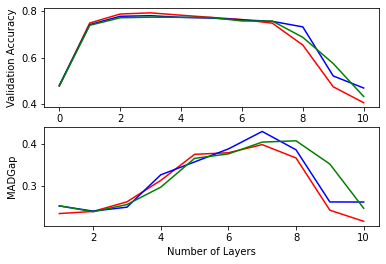

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)

x=num_layers

fig,axs=plt.subplots(2,1)

axs[0].plot(x[:11],GCN_acc[:11],color='r',label='GCN')
axs[0].plot(x[:11],GAT_acc[:11],color='b',label='GAT')
axs[0].plot(x[:11],AttentionGCN_acc[:11],color='g',label='AttentionGCN')
axs[0].set_xlabel('Number of Layers')
axs[0].set_ylabel('Validation Accuracy')

axs[1].plot(x[1:11],GCN_MADGap[1:11],color='r',label='GCN')
axs[1].plot(x[1:11],GAT_MADGap[1:11],color='b',label='GAT')
axs[1].plot(x[1:11],AttentionGCN_MADGap[1:11],color='g',label='AttentionGCN')
axs[1].set_xlabel('Number of Layers')
axs[1].set_ylabel('MADGap')

plt.savefig("GRLQ3.png")

In [ ]:
for l in [GCN_acc,GAT_acc,AttentionGCN_acc,GCN_MADGap,GAT_MADGap,AttentionGCN_MADGap]:
    for j in range(11):
        print(j,l[j])
    print()

0 0.4780000000000001
1 0.7488
2 0.7876
3 0.7926
4 0.7824
5 0.773
6 0.7637999999999999
7 0.7482
8 0.6539999999999999
9 0.4744
10 0.4058

0 0.4805999999999999
1 0.7418000000000001
2 0.7778000000000002
3 0.7804000000000002
4 0.7734000000000001
5 0.7699999999999999
6 0.7626000000000001
7 0.756
8 0.7322
9 0.5209999999999999
10 0.46900000000000003

0 0.4774
1 0.7390000000000001
2 0.7714000000000001
3 0.774
4 0.7732
5 0.7724
6 0.7576
7 0.7571999999999999
8 0.6874
9 0.5744
10 0.43260000000000004

0 1.597052445880067
1 0.23250949398600246
2 0.23762787363161308
3 0.26085702096583513
4 0.31251196672262116
5 0.37551202544335677
6 0.379399673489507
7 0.3989853125318813
8 0.3667792921052922
9 0.24059344189272452
10 0.21378245153836142

0 1.597052445880067
1 0.250895179966223
2 0.238368298783827
3 0.2479141603112371
4 0.3260405528930253
5 0.3571896623576158
6 0.38859966796968715
7 0.43079419006792435
8 0.3864518655406227
9 0.2605306821179736
10 0.26036189950352734

0 1.597052445880067
1 0.25129886154

In [ ]:
from google.colab import files
files.download("GRLQ3.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>